In [13]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from keras.utils.vis_utils import plot_model
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [12]:
import tensorflow as tf
import numpy as np

(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

# Normalization
x_train=x_train/255.

x_test=x_test/255.

x_train.shape

x_train = tf.image.resize(x_train, [224,224]) 

x_test = tf.image.resize(x_test, [224,224]) 

ResourceExhaustedError: {{function_node __wrapped__ResizeBilinear_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[50000,224,224,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ResizeBilinear]

In [11]:
x_train.shape

TensorShape([50000, 224, 224, 3])

In [ ]:
y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

In [33]:
class inception(layers.Layer):
        def __init__(self,f1,f2,f3,f4,f5,f6):
                super(inception,self).__init__()

                self.layer1=Sequential([
                        layers.Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')
                ])
        
                self.layer2=Sequential([
                        layers.Conv2D(filters=f2,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu'),
                        layers.Conv2D(filters=f3,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')

                ])

                self.layer3=Sequential([
                        layers.Conv2D(filters=f4 ,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu'),
                        layers.Conv2D(filters=f5,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')
                ])

                
                self.layer4=Sequential([
                        layers.MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same'),
                        layers.Conv2D(filters=f6,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')
                ])

        def call(self,x):
                return tf.concat([self.layer1(x),self.layer2(x),self.layer3(x),self.layer4(x)],axis=3)


In [43]:
class google_net(Model):
    def __init__(self):
        super(google_net,self).__init__()

        self.stem=Sequential([   
            layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu'),
            layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'),   
            layers.LayerNormalization(),
            layers.Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
            layers.Conv2D(filters=192,kernel_size=(3,3),strides=(2,2),padding='same',activation='relu'),
            layers.LayerNormalization(),
            layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')
        ])

        self.l1=Sequential([
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64),
            layers.MaxPooling2D(pool_size=(1,1),strides=(1,1),padding='same')
        ])
        
        self.l2=Sequential([
            inception(64,96,128,64,64,64)
        ])
        self.l3=Sequential([
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64)
        ])
        
        self.l4=Sequential([
            inception(64,96,128,64,64,64)
        ])
        
        self.l5=Sequential([
            layers.MaxPooling2D(pool_size=(1,1),strides=(1,1),padding='same'),
            inception(64,96,128,64,64,64),
            inception(64,96,128,64,64,64)
        ])
 
        self.fclayer=Sequential([
            layers.AveragePooling2D(pool_size=(1,1),strides=(1,1)),
            layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu'),
            layers.Flatten(),
            layers.Dense(units=256,activation='relu'),
            layers.Dropout(0.7),
            
        ])

        self.finalfc=Sequential([
            layers.AveragePooling2D(pool_size=(7,7),strides=(1,1)),
            layers.Flatten(),
            layers.Dense(units=10,activation='softmax',name='output')     
        ])

        self.ax1=layers.Dense(units=10,activation='softmax',name='ax1')

        self.ax2=layers.Dense(units=10,activation='softmax',name='ax2')  


    def call(self,inputs,training=False):
        x=self.stem(inputs)

        x=self.l1(x)
        
        x1=self.l2(x)
        ax1=self.fclayer(x)
        ax1=self.ax1(ax1)
        
        x1=self.l3(x)
        ax2=self.fclayer(x1)
        ax2=self.ax2(ax2)
        
        x2=self.l4(x1)
        
        x2=self.l5(x2)
        
        x2=self.finalfc(x2)
    
        return x2,ax1,ax2

    def build_graph(self):
        x=Input(shape=(224,224,3))
        return Model(inputs=[x], outputs=self.call(x))

        
model = google_net()

In [44]:
model.build(input_shape=(None, 224, 224, 3))

In [45]:
model.summary()

Model: "google_net_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_396 (Sequential)  (None, 14, 14, 192)      452736    
                                                                 
 sequential_405 (Sequential)  (None, 14, 14, 320)      574400    
                                                                 
 sequential_410 (Sequential)  (None, 14, 14, 320)      305632    
                                                                 
 sequential_423 (Sequential)  (None, 14, 14, 320)      916896    
                                                                 
 sequential_428 (Sequential)  (None, 14, 14, 320)      305632    
                                                                 
 sequential_437 (Sequential)  (None, 14, 14, 320)      611264    
                                                                 
 sequential_438 (Sequential)  (None, 256)             

In [ ]:
plot_model(model,to_file='googlenet_subclass',show_shapes=True)

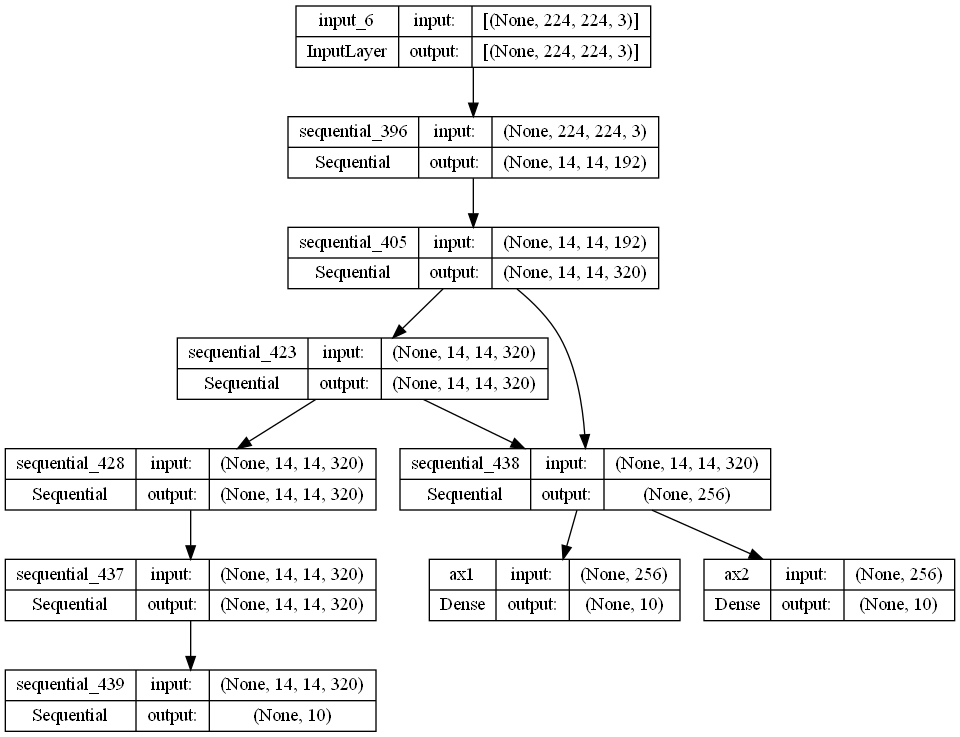

In [46]:
tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='ggsub.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [18]:
#모델만들 때 레이어 이름 지정해주면됨  
model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['acc'],loss_weights={'output':1, 'ax1':0., 'ax2':0})

In [ ]:
history=model.fit(x_train,{'output':y_train,'ax1':y_train,'ax2':y_train},validation_data=(x_test,{'output':y_test,'ax1':y_test,'ax2':y_test}),epochs=10,batch_size=8,verbose=1)

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['acc'],loss_weights={'output_1':1, 'output_2':0., 'output_3':0})

In [21]:
history=model.fit(x_train,{'output_1':y_train,'output_2':y_train,'output_3':y_train},validation_data=(x_test,{'output_1':y_test,'ouyput_2':y_test,'output_3':y_test}),epochs=10,batch_size=8,verbose=1)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\USER\anaconda3\envs\deep\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\USER\anaconda3\envs\deep\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\USER\anaconda3\envs\deep\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\USER\anaconda3\envs\deep\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\USER\anaconda3\envs\deep\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\USER\AppData\Local\Temp\__autograph_generated_filey86s0u6s.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).stem, (ag__.ld(inputs),), dict(training=ag__.ld(training)), fscope)

    ValueError: Exception encountered when calling layer "google_net" "                 f"(type google_net).
    
    in user code:
    
        File "C:\Users\USER\AppData\Local\Temp\ipykernel_6496\349134780.py", line 61, in call  *
            x=self.stem(inputs,training=training)
        File "c:\Users\USER\anaconda3\envs\deep\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "c:\Users\USER\anaconda3\envs\deep\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(8, 32, 32, 3)
    
    
    Call arguments received by layer "google_net" "                 f"(type google_net):
      • inputs=tf.Tensor(shape=(8, 32, 32, 3), dtype=float32)
      • training=True
